## Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/sw_contest"

Mounted at /content/drive
/content/drive/MyDrive/sw_contest


In [2]:
!pip install torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 6.8 MB/s eta 0:00:00


In [3]:
!pip install segmentation_models_pytorch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.6 MB/s eta 0:00:00


In [4]:
!pip install lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import os

import cv2
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Dice
import segmentation_models_pytorch as smp

import albumentations as A
from albumentations.pytorch import ToTensorV2

import lightning as L
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS
from lightning.pytorch.loggers import WandbLogger

In [6]:
import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [7]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

In [8]:
!pip install --upgrade opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 26.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72


## Utils

In [9]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

이미지 보기

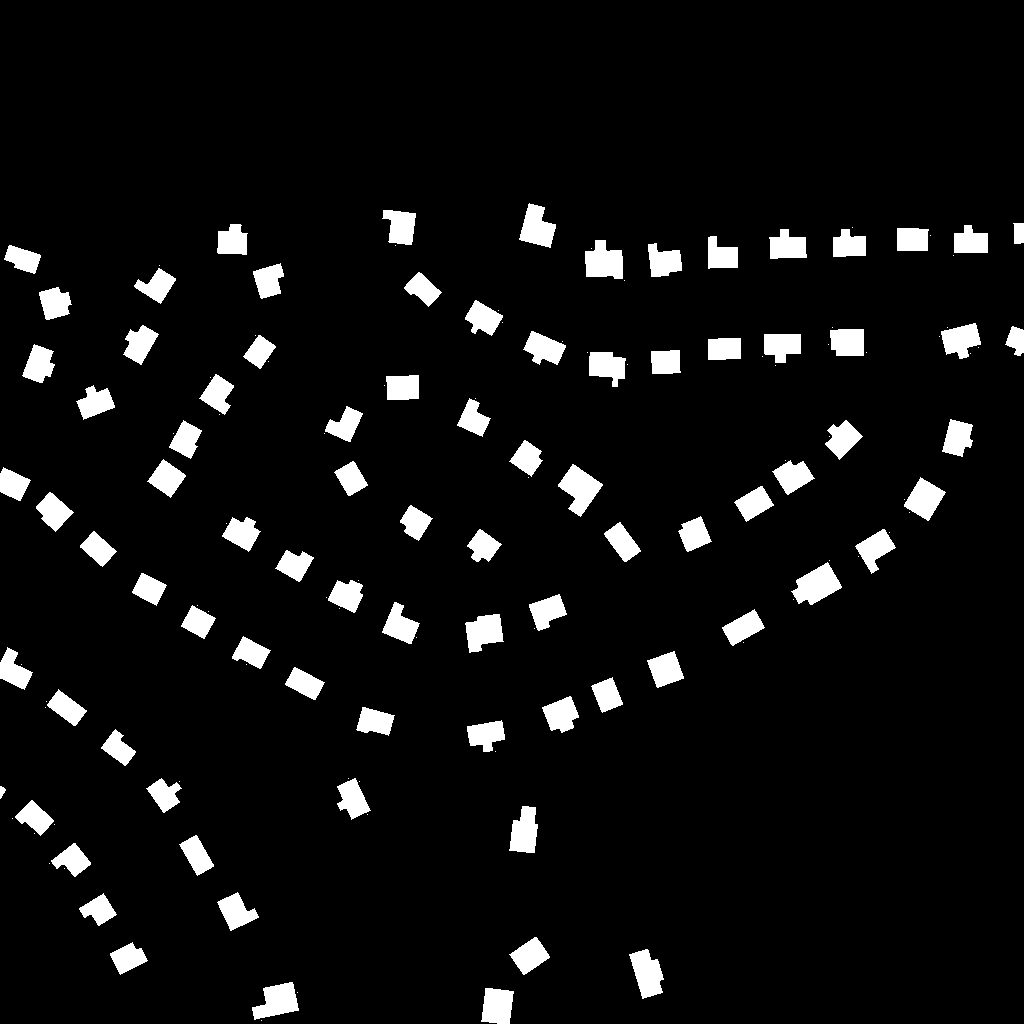

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the image
df = pd.read_csv("./train.csv")

image_path = df.iloc[1,1] # Replace with the path to the image file
image = cv2.imread(image_path)

# Example mask_rle (Replace with the actual mask_rle for TRAIN_0000)
mask_rle = df.iloc[1,2]

# Function to decode mask_rle into binary mask image
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# Convert mask_rle to binary mask image
binary_mask_image = rle_decode(mask_rle, shape=(1024, 1024))

# Convert binary_mask_image to grayscale
gray_mask_image = binary_mask_image * 255

# Find contours in the binary mask image
contours, _ = cv2.findContours(binary_mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw each contour as a line on the original image
for contour in contours:
    cv2.drawContours(image, [contour], -1, (0, 0, 255), 1)  # Red color for the contours

# Display the grayscale mask image using cv2_imshow
cv2_imshow(gray_mask_image)


## Custom Dataset

one-hot encoding 추가

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from typing import List
import torch.nn.functional as F
import sys, os
import os.path as osp

# ... (other imports)

# Define the function for window sliding
def sliding_window(image, mask, window_size):
    h, w = image.shape[:2]
    sub_images = []
    sub_masks = []
    for y in range(0, h, window_size):
        for x in range(0, w, window_size):
            sub_image = image[y:y+window_size, x:x+window_size]
            sub_mask = mask[y:y+window_size, x:x+window_size]
            sub_images.append(sub_image)
            sub_masks.append(sub_mask)
    return sub_images, sub_masks

# ... (rest of the code)

# Use the sliding_window function to split each image and mask into 9 sub-images and masks
window_size = 224  # Set the desired window size
sub_images_list = []
sub_masks_list = []
for image, mask in dataloader:
    image = image.to(device)
    mask = mask.to(device)
    for i in range(image.size(0)):  # Process each image in the batch
        sub_images, sub_masks = sliding_window(image[i], mask[i], window_size)
        sub_images_list.extend(sub_images)
        sub_masks_list.extend(sub_masks)

# Convert sub-images and sub-masks into tensors and create new dataset and dataloader
sub_images_tensor = torch.stack(sub_images_list)
sub_masks_tensor = torch.stack(sub_masks_list)
sub_dataset = torch.utils.data.TensorDataset(sub_images_tensor, sub_masks_tensor)
sub_dataloader = torch.utils.data.DataLoader(sub_dataset, batch_size=20, shuffle=True, num_workers=8)

# Now you can train on the sub-dataloader
# ... (rest of the training code)

In [10]:
def train_transform():
    return A.Compose(
        [
            A.OneOf(
                [
                    A.RandomBrightness(p=1),
                    A.RandomBrightnessContrast(p=1),
                    A.Emboss(p=1),
                    A.RandomShadow(p=1),
                    A.NoOp(),
                ],
                p=1,
            ),
            A.OneOf(
                [
                    A.Blur(p=1),
                    A.AdvancedBlur(p=1),
                    A.MotionBlur(p=1),
                ],
                p=0.6,
            ),
            A.OneOf(
                [
                    A.NoOp(),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.ShiftScaleRotate(p=0.5),
                    A.Rotate(limit=90, p=1, border_mode=cv2.BORDER_REPLICATE),
                    A.RandomRotate90(p=1)
                ],
                p=1,
            ),
            A.RandomCrop(224, 224),
            A.Normalize(),
            ToTensorV2(transpose_mask=True)
        ]
    )

def val_transform():
    return A.Compose(
        [
            A.Resize(224, 224),
            A.Normalize(),
            ToTensorV2(transpose_mask=True)
        ]
    )

def test_transform():
        return A.Compose(
            [
                A.Normalize(),
                ToTensorV2(transpose_mask=True)
            ]
        )

train_transform = train_transform()
val_transform = val_transform()
test_transform = test_transform()



/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  self.max_value = max_value


#Dice Coefficient(Score)

In [11]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, train=False, val=False, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.train = train
        self.val = val
        self.infer = infer
        self.num_classes = 2

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]

        if self.train:
            image = cv2.imread(os.path.join("./train_img", img_name + ".png"), cv2.IMREAD_GRAYSCALE)
            image = np.expand_dims(image, axis=-1)

            mask = cv2.imread(os.path.join("./train_mask", img_name + ".png"), cv2.IMREAD_GRAYSCALE)
            mask = np.expand_dims(mask, axis=-1)

            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

            return image, mask

        elif self.val:
            image = cv2.imread(os.path.join("./train_img3", img_name + ".png"))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask = cv2.imread(os.path.join("./train_mask3", img_name + ".png"), cv2.IMREAD_GRAYSCALE)

            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

            return image, mask

        elif self.infer:
            image = cv2.imread(os.path.join("./train_img", img_name + ".png"))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.transform:
                image = self.transform(image=image)['image']

            return image


val split

In [ ]:
df = pd.read_csv("./train.csv")
train_df, val_df = train_test_split(df, test_size=0.2, random_state=0, shuffle=True)
val_df.to_csv('val2.csv',index=False)

In [ ]:
df = pd.read_csv('./val2.csv')
df

,img_id,img_path,mask_rle
0,TRAIN_4972,./train_img/TRAIN_4972.png,69144 1 70167 3 71190 5 72213 7 73236 9 74259 ...
1,TRAIN_5579,./train_img/TRAIN_5579.png,30887 1 31910 2 32933 4 33955 7 34978 9 36001 ...
2,TRAIN_1656,./train_img/TRAIN_1656.png,285670 4 286694 7 287718 11 288741 15 289765 1...
3,TRAIN_5082,./train_img/TRAIN_5082.png,140552 2 141576 3 142599 6 143622 8 144646 10 ...
4,TRAIN_2193,./train_img/TRAIN_2193.png,1978 1 3040 33 4009 88 5011 110 6035 110 7059 ...
...,...,...,...
1423,TRAIN_3518,./train_img/TRAIN_3518.png,537 23 1561 23 2585 23 3619 13 41026 2 42050 6...
1424,TRAIN_0405,./train_img/TRAIN_0405.png,25518 16 26542 16 27566 16 28590 16 29614 16 3...
1425,TRAIN_0414,./train_img/TRAIN_0414.png,684 32 732 43 809 52 1710 17 1759 21 1784 14 1...
1426,TRAIN_1139,./train_img/TRAIN_1139.png,1 4 54 18 105 34 875 36 1076 20 1129 35 1899 3...


In [12]:
# Define your three models
model1 = SMP(
            encoder_name="timm-regnety_320",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
        )

model2 = SMP(
            encoder_name="resnet152",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
        )

model3 = smp.DeepLabV3Plus(encoder_name="resnet101", encoder_weights="imagenet", in_channels=3, classes=1)



# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)
model2 = model2.to(device)
model3 = model3.to(device)


weight_file_path = '/content/gdrive/MyDrive/unet3_ag/sc_paper2_35.pth'
model2.load_state_dict(torch.load(weight_file_path))

weight_file_path = '/content/gdrive/MyDrive/unet3_ag/sc_paper_15.pth'
model1.load_state_dict(torch.load(weight_file_path))

weight_file_path = '/content/gdrive/MyDrive/unet3_ag/en_kf34_10.pth'
model3.load_state_dict(torch.load(weight_file_path))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s]


In [13]:
#model = smp.UnetPlusPlus(encoder_name="resnet152", encoder_weights="imagenet", in_channels=3, classes=1)

#model = smp.DeepLabV3Plus( encoder_name="resnet152", encoder_weights="imagenet", activation= 'sigmoid', encoder_output_stride = 16, decoder_atrous_rates = (4, 8, 16), in_channels=3, classes=2)
# model = smp.DeepLabV3Plus(encoder_name="resnet101", encoder_weights="imagenet", in_channels=3, classes=2)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# weight_init = torch.load("./JOweights/last_30.pth")
# model.load_state_dict(weight_init, strict=False)

test_dataset = SatelliteDataset(csv_file='./val2.csv', transform=test_transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4)

# Set models to evaluation mode
model1.eval()
model2.eval()
model3.eval()

predictions = []  # List to store the final ensemble predictions

with torch.no_grad():
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)
        # Forward pass through all three models
        out1 = model1(images)
        out2 = model2(images)
        out3 = model3(images)

        # Combine the predictions from the three models (e.g., averaging)
        ensemble_output = (out1 + out2 + out3) / 3

        masks = torch.sigmoid(ensemble_output).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.35).astype(np.uint8) # Threshold = 0.35
        # Apply activation function (e.g., sigmoid) if required for binary segmentation
        # ensemble_output = torch.sigmoid(ensemble_output)

        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)




100%|██████████| 714/714 [02:47<00:00,  4.26it/s]


In [14]:
import pandas as pd

# 이미지 이름 추출
image_names = [img_name for img_name in test_dataset.data.iloc[:, 0]]
result_df = pd.DataFrame(image_names, columns=["image_id"])


# 이미지 경로 추가 (image_name.png 형식)
result_df['image_path'] = result_df['image_id'].apply(lambda x: './train_img2/' + x + '.png')


result_df['mask_rle'] = result

# 결과를 csv 파일로 저장
#result_df.to_csv('result.csv', index=False)


In [ ]:
result_df

,image_id,image_path,mask_rle
0,TRAIN_4972,./train_img2/TRAIN_4972.png,884 43 1906 47 2930 48 3954 47 4978 47 6003 45...
1,TRAIN_5579,./train_img2/TRAIN_5579.png,23 15 1047 16 2070 18 3095 16 4119 12 5144 5 6...
2,TRAIN_1656,./train_img2/TRAIN_1656.png,235505 4 236528 6 237551 8 238575 8 239598 10 ...
3,TRAIN_5082,./train_img2/TRAIN_5082.png,141575 7 142598 11 143621 14 144645 16 145668 ...
4,TRAIN_2193,./train_img2/TRAIN_2193.png,916 5 922 13 941 75 1940 99 2963 100 3986 101 ...
...,...,...,...
1423,TRAIN_3518,./train_img2/TRAIN_3518.png,516 9 540 19 1539 10 1561 23 2562 11 2585 23 3...
1424,TRAIN_0405,./train_img2/TRAIN_0405.png,24495 10 25518 12 26541 15 27565 17 28589 18 2...
1425,TRAIN_0414,./train_img2/TRAIN_0414.png,609 11 691 35 733 30 815 42 902 4 1633 11 1715...
1426,TRAIN_1139,./train_img2/TRAIN_1139.png,46 26 874 36 1068 29 1898 36 2090 31 2922 37 3...


In [15]:
import numpy as np
import pandas as pd
from typing import List, Union
from joblib import Parallel, delayed


def rle_decode(mask_rle: Union[str, int], shape=(224, 224)) -> np.array:
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    if mask_rle == -1:
        return np.zeros(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7) -> float:
    '''
    Calculate Dice Score between two binary masks.
    '''
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)


def calculate_dice_scores(ground_truth_df, prediction_df, img_shape=(224, 224)) -> List[float]:
    '''
    Calculate Dice scores for a dataset.
    '''


    # Keep only the rows in the prediction dataframe that have matching img_ids in the ground truth dataframe
    prediction_df = prediction_df[prediction_df.iloc[:, 0].isin(ground_truth_df.iloc[:, 0])]
    prediction_df.index = range(prediction_df.shape[0])

    # Extract the mask_rle columns
    pred_mask_rle = prediction_df.iloc[:, 2]
    gt_mask_rle = ground_truth_df.iloc[:, 2]


    def calculate_dice(pred_rle, gt_rle):
        pred_mask = rle_decode(pred_rle, img_shape)
        gt_mask = rle_decode(gt_rle, img_shape)


        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None


    dice_scores = Parallel(n_jobs=-1)(
        delayed(calculate_dice)(pred_rle, gt_rle) for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle)
    )


    dice_scores = [score for score in dice_scores if score is not None]  # Exclude None values


    return np.mean(dice_scores)

train = pd.read_csv("./val2.csv")
calculate_dice_scores(train, result_df)
# 0.67

0.10102317796781314